#Fashion MNIST classification with CNN

Dataset load 

torchvision과 transforms를 이용한 dataset 구축

torchvision.datasets.CIFAR10()를 이용하여 array형태의 학습데이터셋을 반환하는 torch.utils.data.Dataset클래스 load  
torchvision.transforms를 이용하여 해당 데이터를 Tensor로 변환하고 Normalize하여 값을 스케일링 한다.

다음 doc참조:  
FashionMNIST:https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html  
transforms: https://pytorch.org/vision/stable/transforms.html

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

#load할 dataset에 사전작업될 이미지 전처리
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5,0.5)])

#torchvision을 통한 dataset load
trainDataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testDataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#batch processing을 위한 dataloader 구성
batch_size = 20

trainDataLoader = torch.utils.data.DataLoader(trainDataset,batch_size=batch_size,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testDataset,batch_size=batch_size,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


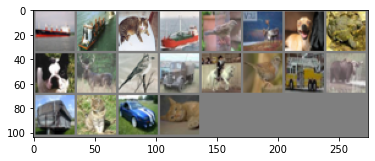

tensor(8) tensor(8) tensor(3) tensor(8) tensor(2) tensor(4) tensor(5) tensor(6) tensor(5) tensor(4) tensor(2) tensor(9) tensor(7) tensor(2) tensor(9) tensor(4) tensor(9) tensor(3) tensor(1) tensor(3)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainDataLoader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

Model 선언
nn.Module를 통해 모델의 구조결정

CNN 기반의 모델을 선언한다.  
모델의 구조는  
LeNet5와 동일한 형태로 구성하며 input data의 channel수는 3으로 가정한다.  


각 오브젝트의 입력과 선언은 다음 doc 참조:  
Conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html  
AvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html  
Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [ ]:
from torch import nn

class myModel(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
      self.relu = nn.ReLU()
      self.pool = nn.AvgPool2d(2, 2)

      self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
      self.conv3 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
      self.ln1 = nn.Linear(120,100)
      self.ln2 = nn.Linear(100,10)


  def forward(self,x):
    #print(x.shape)
    x= self.conv1(x)
    x= self.pool(x)
    #print(x.shape)
    x = self.relu(x)
    #print(x.shape)
    #print(x.shape)
    x= self.conv2(x)
    x= self.pool(x)
    #print(x.shape)
    x=self.relu(x)
    x= self.conv3(x)
    x=self.relu(x)

    x = x.reshape(-1, 120)
    #print(x.shape)
    
    x=self.relu(self.ln1(x))
    #print(x.shape)
    x=self.relu(self.ln2(x))
    #print(x.shape)

    return x


model = myModel()

for i in trainDataLoader:
  model(i[0])
  break



작성한 dataset과 model을 이용하여 딥러닝 프로세스 구현  

pytorch 딥러닝 프로세스
1. dataset, model선언
2. dataset과 model을 통한 결과 예측
3. 예측된 결과를 통해 **loss**연산 및 **loss.backward**
4. **optimizer.step()**를 사용하여 graident update

주요 오브젝트  
torch.nn.CrossEntropyLoss: 문장 분류를 위한 loss 수행  
torch.optim.Adam: Adam optimizer를 통해 gradient update를 수행하는 class

각 오브젝트의 입력과 선언은 다음 doc 참조:  
CrossEntropyLoss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html  
Adam: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [ ]:
from torch.optim import Adam
lf = nn.CrossEntropyLoss().cuda()
optimizer = Adam(model.parameters(),lr=0.0001)


model = myModel().cuda()


for e in range(100):
  print("\n\nepoch",e)
  train_loss = 0
  train_acc = 0
  model.train()

  for i in trainDataLoader:
    optimizer.zero_grad()

    data = i[0]
    data=data.cuda()
    target=i[1]
    target=target.cuda()

    pred = model(data)
    pred_label = torch.argmax(pred, dim = -1)
    train_acc = sum(pred_label == target.reshape(-1))

    target = target.reshape(-1)
    loss = lf(pred, target)
    loss.backward()
    train_loss += loss.item()

    optimizer.step()

  print("train loss = ",train_loss/len(trainDataLoader))   
  print("train accuracy = ",train_acc/len(trainDataset))   

  val_loss = 0
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for i in testDataLoader:
      data = i[0]
      data=data.cuda()
      target=i[1]
      target=target.cuda()

      pred = model(data)

      pred_label = torch.argmax(pred, dim = -1)
      cur_correct = sum(pred_label == target)
      val_acc += cur_correct

      loss = lf(pred, target.reshape(-1))
      val_loss += loss.item()

    optimizer.step()
  print("test loss = ",val_loss/len(testDataLoader))   
  print("test accuracy = ",val_acc/len(testDataset))



epoch 0
train loss =  2.3033673689842225
train accuracy =  tensor(4.0000e-05, device='cuda:0')
test loss =  2.3033360209465026
test accuracy =  tensor(0.0999, device='cuda:0')


epoch 1
train loss =  2.303367367076874
train accuracy =  tensor(4.0000e-05, device='cuda:0')
test loss =  2.3033360209465026
test accuracy =  tensor(0.0999, device='cuda:0')


epoch 2
train loss =  2.3033673588752746
train accuracy =  tensor(0., device='cuda:0')
test loss =  2.3033360209465026
test accuracy =  tensor(0.0999, device='cuda:0')


epoch 3
train loss =  2.3033673731803894
train accuracy =  tensor(4.0000e-05, device='cuda:0')
test loss =  2.3033360209465026
test accuracy =  tensor(0.0999, device='cuda:0')


epoch 4
train loss =  2.3033673661231995
train accuracy =  tensor(2.0000e-05, device='cuda:0')
test loss =  2.3033360209465026
test accuracy =  tensor(0.0999, device='cuda:0')


epoch 5
train loss =  2.303367371273041
train accuracy =  tensor(2.0000e-05, device='cuda:0')
test loss =  2.30333602